# Evaluation Comparison Notebook

This notebook walks through the complete 4-step evaluation workflow:
1. **Initialize** the QA bot
2. **Generate predictions** for test questions
3. **Build the evaluation dataset** (questions + predictions + ground truth)
4. **Score with an evaluation framework** (LangChain, DeepEval, RAGAS, etc.)

---

## Prerequisites

**LangChain + Ollama setup (optional)**
- Install [Ollama](https://ollama.ai/download) and run `ollama pull llama3` (or any model you prefer).
- In your `.env`, set `LANGCHAIN_USE_OLLAMA=true`, `OLLAMA_MODEL=llama3`, and optionally `OLLAMA_BASE_URL`.
- Restart the notebook kernel after updating environment variables so LangChain picks up the new settings.

## Step 1: Initialize the QA Bot

Set up the QA bot with the sample technical documentation. The bot will use TF-IDF retrieval to answer questions.

In [1]:
from pathlib import Path
import json
import sys

root = Path("..").resolve()
sys.path.insert(0, str(root))
sys.path.insert(0, str(root / "src"))

from src.qa_bot import QABot
from evaluations.base_evaluator import EvaluationInput

# Step 1: Initialize the bot with sample technical documentation
bot = QABot(documents_path=root / "data" / "documents" / "sample_docs")
print(
    f"✓ QA bot initialized with documents from {root / 'data' / 'documents' / 'sample_docs'}"
)

✓ QA bot initialized with documents from C:\Users\Owner\source\repos\LiteObject\eval-framework-sandbox\data\documents\sample_docs


## Steps 2 & 3: Generate Predictions & Build Evaluation Dataset

Ask the bot each test question to generate **predictions**, then pair them with **ground truth** answers to create the evaluation dataset.

### What is a prediction?

In this notebook, a **prediction** is simply the answer text produced by the QA bot for each test question. Evaluation frameworks compare that prediction against the corresponding **ground truth** answer to compute metrics.

In [2]:
from evaluations.utils import load_dataset_from_files

questions_path = root / "data" / "test_questions.json"
ground_truth_path = root / "data" / "ground_truth.json"

# Step 2: Generate predictions from the bot for each test question
questions_data = json.loads(questions_path.read_text(encoding="utf-8"))

predictions: dict[str, str] = {}
for item in questions_data:
    response = bot.answer(item["question"])
    predictions[item["id"]] = response.response

print(f"✓ Generated {len(predictions)} predictions")

# Step 3: Build the evaluation dataset (predictions + ground truth)
eval_dataset = list(
    load_dataset_from_files(
        questions_path=questions_path,
        ground_truth_path=ground_truth_path,
        predictions=predictions,
    )
)

print(
    f"✓ Prepared {len(eval_dataset)} evaluation samples with predictions & ground truth"
)

✓ Generated 3 predictions
✓ Prepared 3 evaluation samples with predictions & ground truth


## Step 4: Score with Evaluation Frameworks

#### 4a: Run one or more evaluation frameworks to score how well your QA bot performed. Start with LangChain, then try others (DeepEval, RAGAS).

In [3]:
from evaluations.langchain_eval_runner import LangChainEvalRunner

# Step 4a: LangChain Evaluation
print("\n=== LangChain Evaluation ===")
langchain_runner = LangChainEvalRunner(output_dir=root / "results")
try:
    langchain_result = langchain_runner.evaluate(eval_dataset)
    langchain_summary = {
        "framework": langchain_result.framework,
        "score": langchain_result.score,
        "details": langchain_result.details,
    }
    print(f"✓ Score: {langchain_result.score}")
except Exception as exc:
    langchain_summary = {
        "framework": "langchain",
        "error": str(exc),
    }
    print(f"✗ Error: {exc}")

langchain_summary


=== LangChain Evaluation ===
[LangChain] Using Ollama backend: model=qwen3:8b, base_url=http://localhost:11434
[LangChain] Using Ollama backend: model=qwen3:8b, base_url=http://localhost:11434


C:\Users\Owner\source\repos\LiteObject\eval-framework-sandbox\evaluations\langchain_eval_runner.py:85: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  return chat_ollama_cls(**kwargs)


✓ Score: 0.3333333333333333


{'framework': 'langchain',
 'score': 0.3333333333333333,
 'details': {'raw': [{'reasoning': 'GRADE: CORRECT',
    'value': 'CORRECT',
    'score': 1},
   {'reasoning': 'GRADE: INCORRECT', 'value': 'INCORRECT', 'score': 0},
   {'reasoning': 'GRADE: INCORRECT', 'value': 'INCORRECT', 'score': 0}],
  'provider': 'ollama'}}

In [5]:
from evaluations.deepeval_runner import DeepEvalRunner

# Step 4a: DeepEval Evaluation
print("\n=== DeepEval Evaluation ===")
deepeval_runner = DeepEvalRunner(output_dir=root / "results")
try:
    deepeval_result = deepeval_runner.evaluate(eval_dataset)
    deepeval_summary = {
        "framework": deepeval_result.framework,
        "score": deepeval_result.score,
        "details": deepeval_result.details,
    }
    print(f"✓ Score: {deepeval_result.score}")
except Exception as exc:
    deepeval_summary = {
        "framework": "deepeval",
        "error": str(exc),
    }
    print(f"✗ Error: {exc}")

deepeval_summary


=== DeepEval Evaluation ===
[DeepEval] Using offline word-overlap metric (model config: qwen3:8b)
✓ Score: 0.07407407407407407


{'framework': 'deepeval',
 'score': 0.07407407407407407,
 'details': {'metric': 'word_overlap',
  'num_samples': 3,
  'method': 'offline_comparison'}}

In [6]:
from evaluations.ragas_runner import RagasRunner

# Step 4a: RAGAS Evaluation
print("\n=== RAGAS Evaluation ===")
ragas_runner = RagasRunner(output_dir=root / "results")
try:
    ragas_result = ragas_runner.evaluate(eval_dataset)
    ragas_summary = {
        "framework": ragas_result.framework,
        "score": ragas_result.score,
        "details": ragas_result.details,
    }
    print(f"✓ Score: {ragas_result.score}")
except Exception as exc:
    ragas_summary = {
        "framework": "ragas",
        "error": str(exc),
    }
    print(f"✗ Error: {exc}")

ragas_summary


=== RAGAS Evaluation ===
[RAGAS] Using offline token-overlap metric (Ollama config: model=qwen3:8b, base_url=http://localhost:11434)
✓ Score: 0.07407407407407407


{'framework': 'ragas',
 'score': 0.07407407407407407,
 'details': {'method': 'offline_token_overlap', 'num_samples': 3}}

In [9]:
from evaluations.embedding_eval_runner import EmbeddingEvalRunner

# Step 4a: Embedding-based Evaluation
print("\n=== Embedding Evaluation ===")
embedding_runner = EmbeddingEvalRunner(output_dir=root / "results")
try:
    embedding_result = embedding_runner.evaluate(eval_dataset)
    embedding_summary = {
        "framework": embedding_result.framework,
        "score": embedding_result.score,
        "details": embedding_result.details,
    }
    print(f"✓ Score: {embedding_result.score}")
except Exception as exc:
    embedding_summary = {
        "framework": "embedding",
        "error": str(exc),
    }
    print(f"✗ Error: {exc}")

embedding_summary


=== Embedding Evaluation ===


c:\Users\Owner\source\repos\LiteObject\eval-framework-sandbox\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Owner\source\repos\LiteObject\eval-framework-sandbox\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owner\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activa

[Embedding] Using sentence-transformers (all-MiniLM-L6-v2) for semantic similarity
✓ Score: 0.4449158161878586


{'framework': 'embedding',
 'score': 0.4449158161878586,
 'details': {'metric': 'cosine_similarity',
  'num_samples': 3,
  'method': 'semantic_embedding',
  'embedding_model': 'all-MiniLM-L6-v2'}}

#### Step 4b: Compare Framework Scores

This step collects the overall scores returned by each evaluation framework you ran in Step 4a. Each score is a single aggregate metric between 0 and 1 that summarizes how well the QA bot's predictions matched the ground-truth answers across all test questions for that framework.


=== Framework Comparison ===
LangChain: 0.333
DeepEval: 0.074
RAGAS: 0.074
Embedding: 0.445


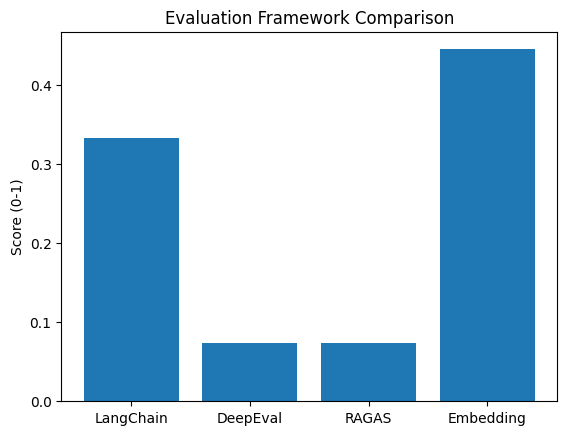

In [10]:
# Collect results from all frameworks evaluated in Step 4a
framework_results = {
    "LangChain": langchain_summary.get("score"),
    "DeepEval": deepeval_summary.get("score"),
    "RAGAS": ragas_summary.get("score"),
    "Embedding": embedding_summary.get("score"),
}

print("\n=== Framework Comparison ===")
for framework, score in framework_results.items():
    if isinstance(score, (int, float)) and score is not None:
        print(f"{framework}: {score:.3f}")
    elif score is not None:
        print(f"{framework}: {score}")
    else:
        print(f"{framework}: Not evaluated or error occurred")

# Optional: Create a simple bar chart if you have multiple numeric results
numeric_scores = {
    k: v for k, v in framework_results.items() if isinstance(v, (int, float))
}
if len(numeric_scores) > 1:
    try:
        import matplotlib.pyplot as plt

        names = list(numeric_scores.keys())
        scores = list(numeric_scores.values())
        plt.bar(names, scores)
        plt.ylabel("Score (0-1)")
        plt.title("Evaluation Framework Comparison")
        plt.show()
    except ImportError:
        print("Install matplotlib for visualization: pip install matplotlib")